## NSMC로 감정 분석(텍스트 분류) 하기

![감정분석 다이어그램](figs/sentiment_analysis.jpg)

> Reference : https://www.kdnuggets.com/2018/03/5-things-sentiment-analysis-classification.html

### 1. 감정분석이란?

* Natural Language Processing, Text Analysis, Computational Lingustics, biometrics 같은 방법을 이용하여 텍스트에 숨겨져있는 저자의 의도나 정보를 찾아내는 모든 방법들을 말한다.


* Opinion Mining, Sentiment Mining, Subjectivity Analysis 라고도 불리기도 한다.


* 초반의 방법들은 텍스트의 극성(Polarity)를 찾기 위해 많이 시도되었다. 대표적인 예로 <b>긍정/부정</b>으로 나누는 케이스가 있다.


* 감정 분석은 크게 Knowledge-based approach, Machine Learning-based approach가 있다.

> Knowledge-based는 알려진 어구, 어미, 관용 표현등을 활용하여 이미 문서들을 human expert가 평가한 데이터를 가져와 평가하는 방법이다.

> ML-based approach는 supervised, unsupervised 방법이 있다. 최근 pretrained Language Model이 비약적으로 발달함에 따라 unsupervised 방법의 성능도 많이 높아졌지만, 아직까지는 성능면에선 supervised가 월등히 높다.

* 따라서, 가장 많이 쓰이는 방법인 text classification으로서의 sentiment analysis를 공부해보고, 추가적으로 생각해볼 여러 가지 이슈에 대해 고민해보는 시간을 가진다.

<img src="figs/sentiment_diagram.png" width="500">

### 2. 텍스트 분류란?

* 벡터 형태로 표현된 텍스트를 말그대로 분류하는 방법이다.


* DNN이 비약적으로 성능 향상을 가져오기 전까지는 SVM이 가장 많이 사용되었다.


* 현재는 CNN, LSTM을 분류 모델로 가장 많이 사용한다.


* 실제로 텍스트 분류 작업은 큰 범위에서 대부분의 NLP downstream task를 포함한다.


* 하나의 예로, Siamese Network라는 걸 통해서 Question-Answering pair를 학습하게 되면, 분류의 기준이 "특정 질문에 맞는 정답을 잘 골랐는가 아닌가(0 / 1)"를 해결하는 문제로 바뀌게 된다.

<img src="figs/text_classification.png" width="400">

### 3. scikit-learn으로 NSMC 감정분석 하기

* 저번 시간에 했던 코드를 그대로 가져와, nsmc를 불러옵니다.

In [1]:
def read_documents(filename):
    with open(filename, encoding='utf-8') as f:
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:]
        
    return documents
    
train_docs = read_documents("data/nsmc/ratings_train.txt")
test_docs = read_documents("data/nsmc/ratings_test.txt")

In [2]:
print(len(train_docs))
print(len(test_docs))

150000
50000


In [3]:
import re

def mecab_nouns(text):
    nouns = []
    pattern = re.compile('.*\t[A-Z]+')
    temp = [tuple(pattern.match(token).group(0).split('\t')) for token in mecab.parse(text).splitlines()[:-1]]    
    for token in temp:  # 추출한 token중에 POS가 명사 분류에 속하는 토큰만 선택.
        if re.match('N[A-Z]+', token[1]):
            nouns.append(token[0])
    return nouns

def mecab_morphs(text):
    morphs = []
    pattern = re.compile(".*\t[A-Z]+")
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]] 
    for token in temp:  # 추출한 token중에 문자열만 선택.
        morphs.append(token[0])
    return morphs

def mecab_pos(text):
    pos = []
    pattern = re.compile(".*\t[A-Z]+") # 토큰이름, 탭, 품사종류
    pos = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
    return pos

In [4]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):
    SW = set()
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word)
    return SW

def text_tokenizing(doc):
    # wordcloud를 위해 모든 형태소 추출하는 경우.
    return [word for word in mecab_morphs(doc) if word not in SW and len(word) > 1]
    
    # wordcloud를 위해 명사만 추출하는 경우.
#     return [word for word in mecab_nouns(doc) if word not in SW and len(word) > 1]

* 불러온 데이터를 품사 태그를 붙여서 토크나이징합니다.

In [5]:
import MeCab
# from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint

# okt = Okt()
mecab = MeCab.Tagger()

SW = define_stopwords("data/stopwords-ko.txt")

if os.path.exists('train_docs.json'):
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    # cleaning -> tokenizing 과 tokenizing -> cleaning 의 결과는 동일하다
    # cleaning -> tokenizing 이것이 속도나 코드 측면에서 좋다
    train_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in train_docs if text_tokenizing(text_cleaning(line[1]))]
    #train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in test_docs if text_tokenizing(text_cleaning(line[1]))]
    #test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

(['진짜', '짜증', '네요', '목소리'], '0')
(['평점', '나쁘', '지만', '짜리', '더더욱', '아니', '잖아'], '0')


In [8]:
print(len(train_data))
print(len(test_data))

146469
48876


* 데이터 분석을 하기 위해 기본적인 정보들을 확인합니다.

* nltk 라이브러리를 이용하여 전처리를 합니다.

In [9]:
import nltk

total_tokens = [token for doc in train_data for token in doc[0]]
print(len(total_tokens))

1138353


In [10]:
text = nltk.Text(total_tokens, name='NMSC')
print(len(set(text.tokens)))
pprint(text.vocab().most_common(10))

48022
[('영화', 57601),
 ('는데', 11464),
 ('너무', 11013),
 ('정말', 9779),
 ('으로', 9314),
 ('재밌', 8988),
 ('네요', 8979),
 ('지만', 8654),
 ('진짜', 8327),
 ('에서', 8064)]


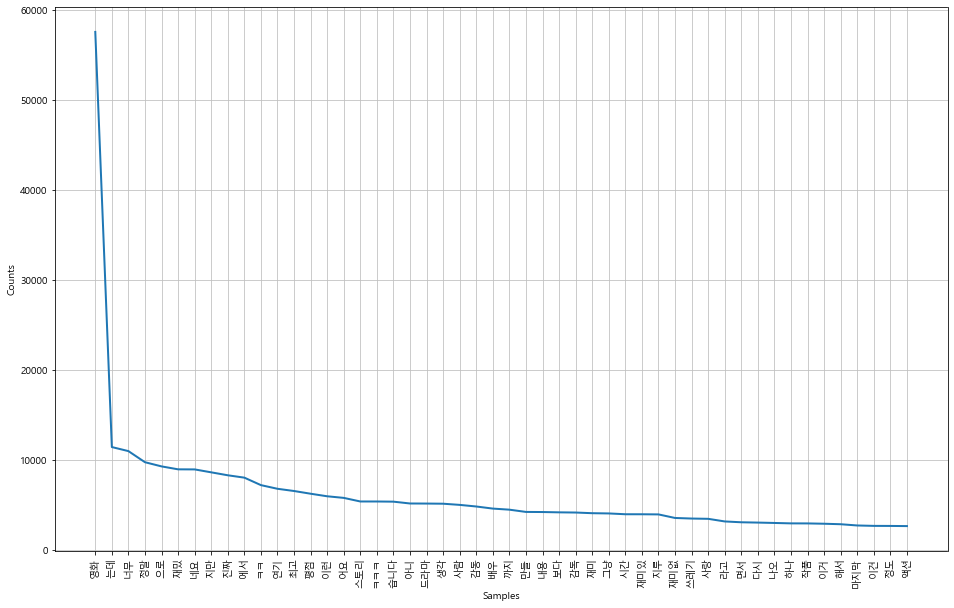

In [11]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(16, 10))
text.plot(50)

In [12]:
# 여러 리스트들을 하나로 묶어 주는 함수입니다.
def list_to_str(List): 
    return " ".join(List)

### 4. Linear Classifier와 Support Vector Machine으로 nsmc 분류하기

#### tf-idf와 count_vectorizer 설명 : https://wiserloner.tistory.com/917
- CountVectorizer : 각 텍스트에서 단어 출현 횟수를 카운팅한 벡터

- TfidfVectorizer : TF-IDF라는 값을 사용하여 CountVectorizer의 단점을 보완

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# 학습을 위해 데이터셋 모양 통일하기
train_x = [list_to_str(doc) for doc, _ in train_data]
test_x = [list_to_str(doc) for doc, _ in test_data]
train_y = [label for _, label in train_data]
test_y = [label for _, label in test_data]

#print(len(train_x), len(train_y))
print("For %d train data" % len(train_x))
#print(len(test_x), len(test_y))

# 1. perceptron linear classifier
learner = Pipeline([
    ('vect', CountVectorizer()), # max_features=500 -> 가장 많이나온 500개만 돌림..
                                 # min_df=5 -> 5번 이하로 나온 단어는 버림
#     ('vect', TfidfVectorizer()),
    ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                         alpha=1e-4, random_state=42,
                         max_iter=100))
])

# 2. SVM with linear kernel
learner2 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='linear'))
    
])

# 3. SVM with polynomial kernel
learner3 = Pipeline([
    ('vect', CountVectorizer()),
#     ('vect', TfidfVectorizer()), ## 이렇게  tf-idf 사용 가능
    ('clf', SVC(kernel='poly', degree=8))
])

# 4. SVM with Radius Basis Function kernel 
learner4 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='rbf'))
])

# 5. SVM with sigmoid kernel
learner5 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='sigmoid'))
])

# 6. naive bayse classifier (multinomial ver.)
learner6 = Pipeline([
    ('vect', CountVectorizer()),
    ('mb', MultinomialNB())
])

# 학습기 정하기
classifier = learner
classifier.fit(train_x, train_y)

# 학습
train_predict = classifier.predict(train_x)
train_accuracy = np.mean(train_predict == train_y)

test_predict = classifier.predict(test_x)
test_accuracy = np.mean(test_predict == test_y)


print("For %d test data" % len(test_x))

print("Training Accuracy : %.2f" % train_accuracy)
print("Test Accuracy : %.2f" % test_accuracy)

For 146469 train data
For 48876 test data
Training Accuracy : 0.85
Test Accuracy : 0.78


### < 실험결과 >

#### Linear Classifier 학습하여, test accuracy를 측정. (learner)

1. 명사만 추출 : 0.51
2. 전처리 하지 않고 형태소 분석 : 0.67
3. 전처리 하고 형태소 분석 : 0.71

-----여기까진 top 500 features만 사용--------
4. 3 + 모든 feature : 0.76

### < 실험결과 >

#### SVM Classifier 학습하여, test accuracy를 측정. (learner2)

1. 명사만 추출 : 0.53
2. 전처리 하지 않고 형태소 분석 : 0.72
3. 전처리 하고 형태소 분석 : 0.77

-----여기까진 top 500 features만 사용--------
4. 3 + 모든 feature : 0.81